In [193]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root / "src"))

In [194]:
import torch
import pandas as pd
from models.base.lightgbm_model import LightGBMClassifierModel
import numpy as np
from utils.analysis import platt_scaled_predictions, evaluate

FEATURES_PATH = "../src/data/patch_entropy.csv"
EMBEDDINGS_PATH = "../src/data/patch_embeddings.pt"
MODEL_SAVE_PATH = "../src/output/entropy_lgbm_model.pkl"

print(f"Loading features from: {FEATURES_PATH}")
dataset_feats = pd.read_csv(FEATURES_PATH)

print(f"Loading embeddings from: {EMBEDDINGS_PATH}")
dataset_embs = torch.load(EMBEDDINGS_PATH, weights_only=False)

if isinstance(dataset_embs, torch.Tensor):
    dataset_embs = dataset_embs.numpy()

print("Initializing LightGBM model...")
model = LightGBMClassifierModel(ds_feats=dataset_feats, ds_embs=dataset_embs)
model.split_data()
model.load_model(MODEL_SAVE_PATH)

print("Evaluating model...")
y_pred, y_proba = model.predict(model.X_test)
results = evaluate(y_pred, y_proba, model.y_test)

oof_probs = model.oof_predict()
calibrated_probs = platt_scaled_predictions(oof_probs, model.y_train)

Loading features from: ../src/data/patch_entropy.csv
Loading embeddings from: ../src/data/patch_embeddings.pt
Initializing LightGBM model...
Evaluating model...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warni

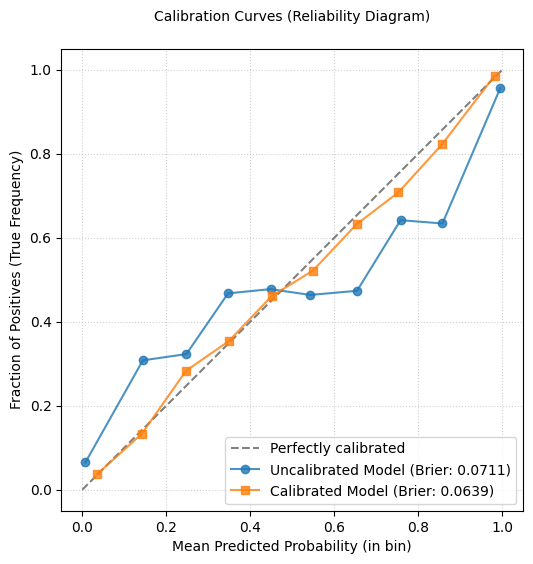

Uncalibrated Brier Score: 0.0711
Calibrated Brier Score:   0.0639


In [195]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# brier scores
brier_uncalibrated = brier_score_loss(model.y_train, oof_probs)
brier_calibrated = brier_score_loss(model.y_train, calibrated_probs)

# calibration curves
prob_true_uncal, prob_pred_uncal = calibration_curve(model.y_train, oof_probs, n_bins=10, strategy="uniform")
prob_true_cal, prob_pred_cal = calibration_curve(model.y_train, calibrated_probs, n_bins=10, strategy="uniform")

plt.figure(figsize=(6, 6))

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")

plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', linestyle='-',
         label=f"Uncalibrated Model (Brier: {brier_uncalibrated:.4f})", alpha=0.8)

plt.plot(prob_pred_cal, prob_true_cal, marker='s', linestyle='-',
         label=f"Calibrated Model (Brier: {brier_calibrated:.4f})", alpha=0.8)

plt.xlabel("Mean Predicted Probability (in bin)", fontsize=10)
plt.ylabel("Fraction of Positives (True Frequency)", fontsize=10)
plt.title("Calibration Curves (Reliability Diagram)", fontsize=10, pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Make axes equal
plt.show()

print(f"Uncalibrated Brier Score: {brier_uncalibrated:.4f}")
print(f"Calibrated Brier Score:   {brier_calibrated:.4f}")

In [196]:
from services.vectorstore import FAISSStore
INDEX_SAVE_PATH = "../src/data/local_index.faiss"

store = FAISSStore()
store.load_index(INDEX_SAVE_PATH)

In [197]:
from tqdm import tqdm

results = {}

for i, emb in enumerate(tqdm(model.emb_test, desc="Searching neighbors")):
    sim, ids, probs = store.search_neighbors(emb, calibrated_probs)
    results[i] = {
        "neighbor_sim": sim,
        "neighbor_ids": ids,
        "neighbor_probs": probs,
        "pred_prob": y_proba[i],
        "true_pred": model.y_test.iloc[i]
    }

Searching neighbors: 100%|██████████| 1988/1988 [00:23<00:00, 85.83it/s]


In [198]:
print(results[0])

{'neighbor_sim': array([[0.89136803, 0.88313246, 0.88204575, 0.8695148 , 0.8676531 ]],
      dtype=float32), 'neighbor_ids': array([[5152, 1579, 3060, 5677, 5173]]), 'neighbor_probs': array([[0.04915871, 0.0517147 , 0.09596742, 0.0536536 , 0.09282779]]), 'pred_prob': np.float64(0.008192860939089061), 'true_pred': np.int64(0)}


In [199]:
errors = []
for i, entry in results.items():
    true_label = model.y_test.iloc[i]
    pred_prob = entry["pred_prob"]
    pred_class = int(pred_prob > 0.5)
    if pred_class != true_label:
        errors.append(i)

print(f"Total errors: {len(errors)} / {len(model.y_test)}")

Total errors: 155 / 1988


In [200]:
error_stats = []
for i in errors:
    entry = results[i]
    p = entry["pred_prob"]
    neigh_p = entry["neighbor_probs"].ravel()
    sims = entry["neighbor_sim"].ravel()
    neighbor_var = np.var(neigh_p)
    
    error_stats.append({
        "index": i,
        "true": model.y_test.iloc[i],
        "pred_prob": p,
        "neighbor_var": neighbor_var
    })

In [201]:
for i in errors[:5]:
    entry = results[i]
    print(f"Index {i}, true {model.y_test.iloc[i]}, pred {entry['pred_prob']:.3f}")
    print("Top-k neighbor probs:", entry["neighbor_probs"].ravel())
    print("Top-k similarities:", entry["neighbor_sim"].ravel())

Index 14, true 1, pred 0.215
Top-k neighbor probs: [0.35067107 0.26405961 0.58183756 0.19438893 0.08861048]
Top-k similarities: [0.99041915 0.98958826 0.98421514 0.9817935  0.981467  ]
Index 16, true 0, pred 0.706
Top-k neighbor probs: [0.26265558 0.02671991 0.30427231 0.05943211 0.03239654]
Top-k similarities: [0.8586178  0.8507555  0.84813315 0.8420917  0.8377588 ]
Index 22, true 0, pred 0.643
Top-k neighbor probs: [0.01884087 0.04907764 0.92773305 0.0702289  0.98787449]
Top-k similarities: [0.8379817  0.8327429  0.8317169  0.8301711  0.83013475]
Index 34, true 1, pred 0.375
Top-k neighbor probs: [0.21254539 0.09516788 0.9601972  0.0957069  0.98905454]
Top-k similarities: [0.99102557 0.9821888  0.9603313  0.95147806 0.9444542 ]
Index 39, true 1, pred 0.327
Top-k neighbor probs: [0.0617171  0.99886044 0.97230998 0.00705155 0.99395346]
Top-k similarities: [0.95580304 0.9450158  0.9449736  0.9443238  0.9436872 ]


In [202]:
import numpy as np

irreducible_errors = []

for i in errors:  # errors = indices where model prediction != y_test
    entry = results[i]
    pred_label = int(entry['pred_prob'] > 0.5)
    neigh_labels = (entry['neighbor_probs'].ravel() > 0.5).astype(int)
    
    # Count neighbors agreeing with the model prediction
    agree_count = np.sum(neigh_labels == pred_label)
    
    if agree_count >= 4:  # 80% agreement
        irreducible_errors.append(i)

print(f"Total errors: {len(errors)}")
print(f"Irreducible errors (>=4 neighbors agree with wrong prediction): {len(irreducible_errors)}")
print("Indices of irreducible errors:", irreducible_errors)

Total errors: 155
Irreducible errors (>=4 neighbors agree with wrong prediction): 17
Indices of irreducible errors: [14, 142, 174, 184, 322, 411, 573, 709, 832, 871, 1052, 1165, 1438, 1580, 1631, 1641, 1651]


In [203]:
ps = np.array([results[r]['pred_prob'] for r in results])
neigh_ps = np.array([results[r]['neighbor_probs'] for r in results])
sims_arr = np.array([results[r]['neighbor_sim'] for r in results])

In [204]:
from models.corrector import CounterfactualCorrector

cf_engine = CounterfactualCorrector()
print("[INFO] Adjusting predictions with counterfactual correction...")
cf_results = cf_engine.compute_batch(ps, neigh_ps, sims_arr)

for cf_item, r_index in zip(cf_results, results):
    cf_item['true_class'] = results[r_index]['true_pred']
    cf_item['base_proba'] = results[r_index]['pred_prob']

[INFO] Adjusting predictions with counterfactual correction...


In [205]:
from collections import Counter

counts = Counter()

for i, entry in enumerate(cf_results):
    adj_pred = int(entry["adjusted_proba"] > 0.5)
    true_class = entry["true_class"]
    use_llm = entry["use_llm"]

    if use_llm and adj_pred != true_class:
        counts["llm_used_on_error"] += 1        # correctly flagged
    elif use_llm and adj_pred == true_class:
        counts["llm_used_unneeded"] += 1       # flagged but actually correct
    elif not use_llm and adj_pred != true_class:
        counts["llm_missed_error"] += 1        # missed opportunity
    else:
        counts["llm_correct_no_llm"] += 1      # correct and not flagged

print(counts)

Counter({'llm_correct_no_llm': 1703, 'llm_used_unneeded': 176, 'llm_used_on_error': 71, 'llm_missed_error': 38})


In [206]:
# List to store missed errors
missed_errors = []

for sample_id, entry in enumerate(cf_results):
    adj_pred = int(entry["adjusted_proba"] > 0.5)
    true_class = entry["true_class"]

    # Missed errors: LLM was not used, but prediction was wrong
    if adj_pred != true_class:
        missed_errors.append({
            "id": sample_id,
            "adjusted_proba": entry["adjusted_proba"],
            "pred_class": adj_pred,
            "base_proba": entry["base_proba"],
            "true_class": true_class,
            "ss": entry["ss"],
            "cp": entry["cp"],
            "fi": entry["fi"],
        })

print(f"Total missed errors: {len(missed_errors)}")


Total missed errors: 109


In [207]:
from collections import Counter

llm_stats = Counter({
    "llm_used_on_irreducible": 0,
    "llm_missed_irreducible": 0,
    "llm_used_on_fixable": 0,
    "llm_missed_fixable": 0
})

for entry_id, entry in enumerate(cf_results):
    adj_pred = int(entry["adjusted_proba"] > 0.5)
    true_class = entry["true_class"]
    use_llm = entry["use_llm"]
    
    is_error = adj_pred != true_class
    is_irreducible = entry_id in irreducible_errors
    
    if use_llm and is_error:
        if is_irreducible:
            llm_stats["llm_used_on_irreducible"] += 1
        else:
            llm_stats["llm_used_on_fixable"] += 1
    elif not use_llm and is_error:
        if is_irreducible:
            llm_stats["llm_missed_irreducible"] += 1
        else:
            llm_stats["llm_missed_fixable"] += 1

print(llm_stats)


Counter({'llm_used_on_fixable': 64, 'llm_missed_fixable': 28, 'llm_missed_irreducible': 10, 'llm_used_on_irreducible': 7})


In [208]:
import numpy as np
y_pred_new = []

for i in range(len(model.y_test)):
    ap = cf_results[i]['adjusted_proba']
    
    y_pred_new.append(ap)

y_pred_new = np.array(y_pred_new)

In [209]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Original binary predictions
y_pred_orig = (y_pred > 0.5).astype(int)

# New binary predictions after selective adjustment
y_pred_new_labels = (y_pred_new > 0.5).astype(int)

# Compute number of samples that were corrected
corrected_mask = (y_pred_orig != model.y_test.values) & (y_pred_new_labels == model.y_test.values)
num_corrected = np.sum(corrected_mask)
total_errors = np.sum(y_pred_orig != model.y_test.values)

print(f"Total original errors: {total_errors}")
print(f"Errors corrected by selective adjustment: {num_corrected}")
print(f"Percentage corrected: {100 * num_corrected / total_errors:.2f}%")

# Optionally, show new classification report
print("\nClassification report after selective adjustment:")
print(classification_report(model.y_test, y_pred_new_labels))

# ROC-AUC
print("\nROC-AUC after adjustment:", roc_auc_score(model.y_test, y_pred_new))

Total original errors: 155
Errors corrected by selective adjustment: 65
Percentage corrected: 41.94%

Classification report after selective adjustment:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1024
           1       0.97      0.91      0.94       964

    accuracy                           0.95      1988
   macro avg       0.95      0.94      0.94      1988
weighted avg       0.95      0.95      0.95      1988


ROC-AUC after adjustment: 0.9879013631353735


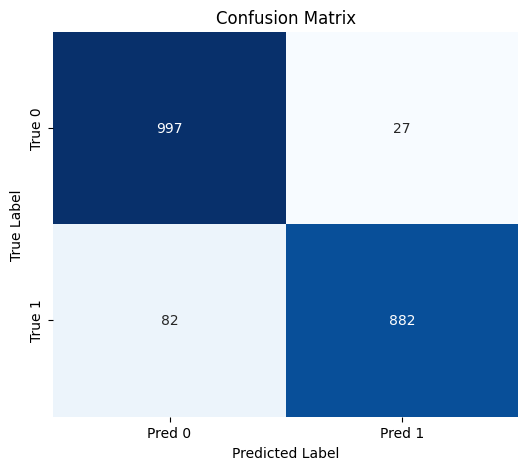

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(model.y_test, y_pred_new_labels)

# Plot with seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [211]:
import numpy as np
from models.corrector import CounterfactualCorrector

def analyze_correction(alpha_val, ps_orig, neigh_ps, sims_arr):
    """
    Runs the counterfactual correction for a given alpha and
    returns a dictionary of performance change metrics.
    
    Args:
        alpha_val (float): The 'alpha' parameter for the corrector.
        ps_orig (np.array): The original model probability predictions.
        neigh_ps (np.array): Neighbor probabilities.
        sims_arr (np.array): Neighbor similarities.
    
    Returns:
        dict: A dictionary containing the analysis results.
    """
    
    # 1. Initialize and run the counterfactual correction
    print(f"[INFO] Running correction for alpha = {alpha_val}...")
    cf_engine = CounterfactualCorrector()
    cf_engine.config.alpha = alpha_val
    cf_results = cf_engine.compute_batch(ps_orig, neigh_ps, sims_arr)
    
    # 2. Get the new, adjusted probabilities
    y_pred_new_probs = np.array([res['adjusted_proba'] for res in cf_results])

    # 3. Calculate binary labels based on 0.5 threshold
    y_pred_orig_labels = (ps_orig > 0.5).astype(int)
    y_pred_new_labels = (y_pred_new_probs > 0.5).astype(int)

    y_true = model.y_test.values

    # 4. Generate error masks
    orig_wrong = (y_pred_orig_labels != y_true)
    new_wrong  = (y_pred_new_labels != y_true)
    
    fixed       = orig_wrong & ~new_wrong  # Was wrong, now correct
    regressed   = ~orig_wrong & new_wrong  # Was correct, now wrong
    still_wrong = orig_wrong & new_wrong  # Was wrong, still wrong

    # 5. Compile results
    total_before = orig_wrong.sum()
    total_after = new_wrong.sum()
    
    results = {
        "alpha": alpha_val,
        "errors_before": total_before,
        "errors_after": total_after,
        "net_error_change": total_after - total_before,
        "errors_fixed": fixed.sum(),
        "new_errors_ (regressed)": regressed.sum(),
        "errors_persistent": still_wrong.sum()
    }
    
    return results

In [212]:
# List of alphas to test
alphas_to_test = [1.0, 0.6]

# Collect results here
analysis_results = []

for alpha in alphas_to_test:
    # Use the 'ps' array as the original predictions
    report = analyze_correction(alpha, ps, neigh_ps, sims_arr)
    analysis_results.append(report)

# 3. Display results in a clean DataFrame
df_analysis = pd.DataFrame(analysis_results)
df_analysis.set_index("alpha", inplace=True)

print("\n--- Counterfactual Correction Analysis ---")
print(df_analysis)

[INFO] Running correction for alpha = 1.0...
[INFO] Running correction for alpha = 0.6...

--- Counterfactual Correction Analysis ---
       errors_before  errors_after  net_error_change  errors_fixed  \
alpha                                                                
1.0              155           122               -33            78   
0.6              155           109               -46            65   

       new_errors_ (regressed)  errors_persistent  
alpha                                              
1.0                         45                 77  
0.6                         19                 90  


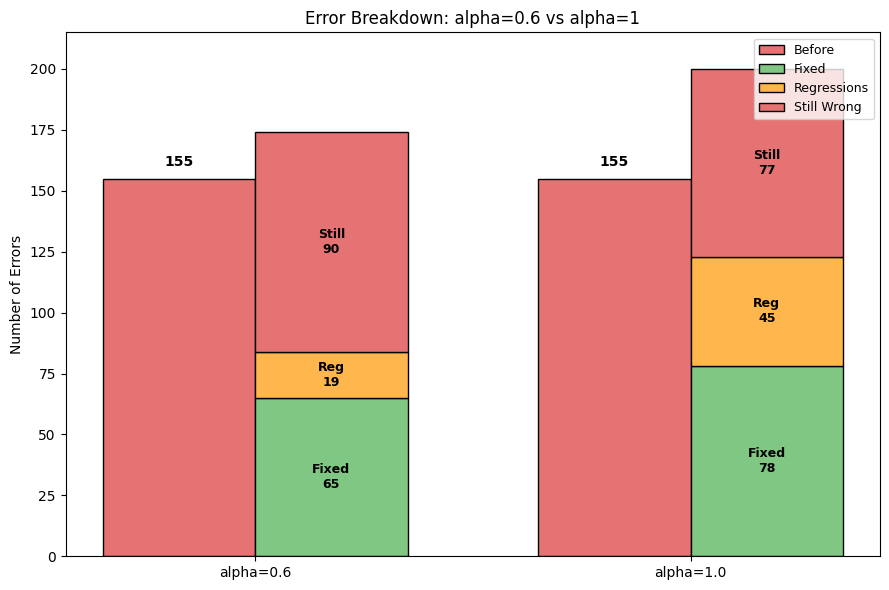

In [213]:
row_0_6 = df_analysis.loc[0.6]
row_1_0 = df_analysis.loc[1.0]

data = {
    "alpha=0.6": {
        "Before": row_0_6['errors_before'],
        "Fixed": row_0_6['errors_fixed'],
        "Regressions": row_0_6['new_errors_ (regressed)'],
        "Still Wrong": row_0_6['errors_persistent'],
        "After": row_0_6['errors_after'], # Total after
    },
    "alpha=1.0": {
        "Before": row_1_0['errors_before'],
        "Fixed": row_1_0['errors_fixed'],
        "Regressions": row_1_0['new_errors_ (regressed)'],
        "Still Wrong": row_1_0['errors_persistent'],
        "After": row_1_0['errors_after'], # Total after
    },
}

# Colors
colors = {
    "Before": "#e57373",      # red-ish
    "Fixed": "#81c784",       # green
    "Regressions": "#ffb74d", # orange
    "Still Wrong": "#e57373"  # red-ish
}

labels = list(data.keys())
x = np.arange(len(labels))  # [0,1] positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(9, 6))

# Plot "Before" bars
before_vals = [data[l]["Before"] for l in labels]
ax.bar(x - width/2, before_vals, width, color=colors["Before"], edgecolor="black", label="Before")

# Plot "After" stacked bars
for i, l in enumerate(labels):
    fixed = data[l]["Fixed"]
    regressions = data[l]["Regressions"]
    still_wrong = data[l]["Still Wrong"]

    ax.bar(x[i] + width/2, fixed, width, color=colors["Fixed"], edgecolor="black")
    ax.bar(x[i] + width/2, regressions, width, bottom=fixed, color=colors["Regressions"], edgecolor="black")
    ax.bar(x[i] + width/2, still_wrong, width, bottom=fixed+regressions, color=colors["Still Wrong"], edgecolor="black")

    # Keep only BEFORE totals above bars
    ax.text(x[i] - width/2, data[l]["Before"] + 5, f'{data[l]["Before"]}', 
            ha='center', fontsize=10, fontweight='bold')

    # Annotate inside stacked bars
    ax.text(x[i] + width/2, fixed/2, f'Fixed\n{fixed}', ha='center', va='center', fontsize=9, fontweight='bold')
    ax.text(x[i] + width/2, fixed + regressions/2, f'Reg\n{regressions}', ha='center', va='center', fontsize=9, fontweight='bold')
    ax.text(x[i] + width/2, fixed + regressions + still_wrong/2, f'Still\n{still_wrong}', ha='center', va='center', fontsize=9, fontweight='bold')

# Labels and formatting
ax.set_ylabel('Number of Errors')
ax.set_title('Error Breakdown: alpha=0.6 vs alpha=1')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Increase y limit for breathing room
ax.set_ylim(0, max(before_vals) + 60)

# Smaller legend
ax.legend(
    ["Before", "Fixed", "Regressions", "Still Wrong"],
    loc='upper right',
    fontsize=9,
    markerscale=0.8,
    frameon=True
)

plt.tight_layout()
plt.show()

In [214]:
irreducible_corrected = [i for i in irreducible_errors if i in np.where(corrected_mask)[0]]

print(f"Number of irreducible errors corrected: {len(irreducible_corrected)}")
print("Indices:", irreducible_corrected)

Number of irreducible errors corrected: 0
Indices: []


In [215]:
# Mask for errors that were not corrected
uncorrected_mask = (y_pred_orig != model.y_test.values) & (y_pred_new_labels != model.y_test.values)
num_uncorrected = np.sum(uncorrected_mask)

print(f"Errors not corrected by selective adjustment: {num_uncorrected}")
print(f"Percentage of original errors still wrong: {100 * num_uncorrected / total_errors:.2f}%")

Errors not corrected by selective adjustment: 90
Percentage of original errors still wrong: 58.06%


In [216]:
# irreducible_errors = indices where >=4 neighbors agree with wrong prediction
# errors = all indices where model prediction != true label

# Keep only errors that are NOT irreducible
analyzable_errors = [i for i in errors if i not in irreducible_errors]

print(f"Total errors: {len(errors)}")
print(f"Irreducible errors: {len(irreducible_errors)}")
print(f"Errors we can analyze (non-irreducible): {len(analyzable_errors)}")

Total errors: 155
Irreducible errors: 17
Errors we can analyze (non-irreducible): 138


epsilon (nominal): 0.100


computed q: 0.991772
acceptance rate: 0.892
selective accuracy (on accepted): 0.922
selective error (on accepted): 0.078


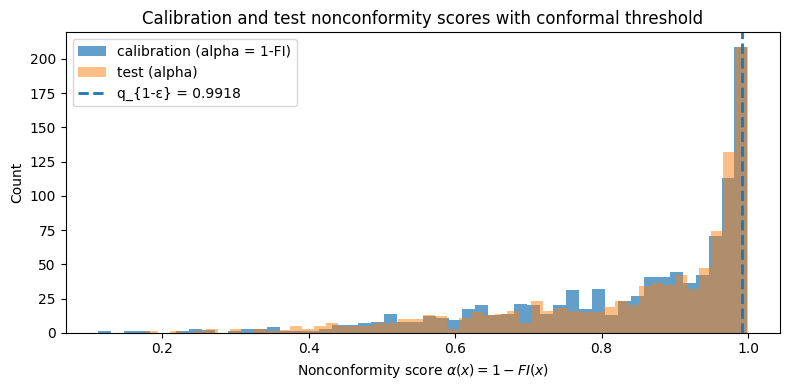

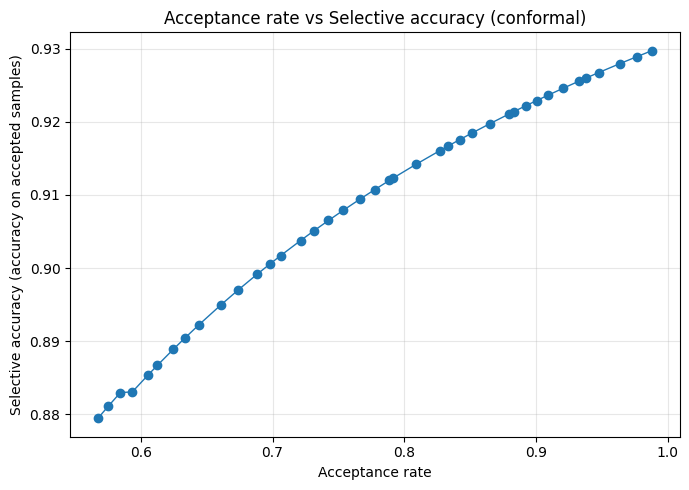

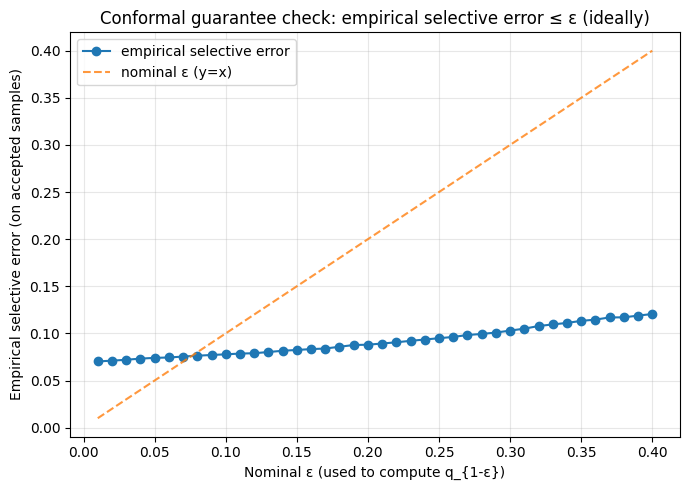

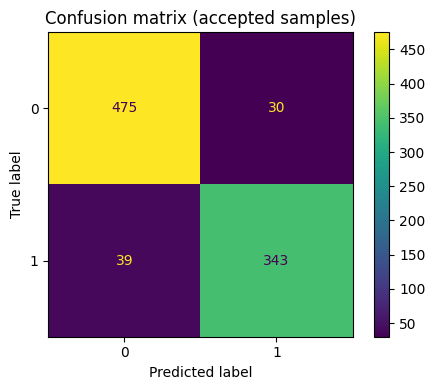

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------------
# Helper: extract arrays from scores_dict
# --------------------------
def extract_arrays(scores_dict):
    items = list(scores_dict)
    FI = np.array([float(s.get('fi', np.nan)) for s in items])
    model_score = np.array([float(s.get('base_proba', np.nan)) for s in items])
    y_true = np.array([int(s.get('true_class', np.nan)) for s in items])
    # predicted label (binary) - adjust threshold if needed (0.5 assumed)
    y_pred = (model_score > 0.5).astype(int)
    correct = (y_pred == y_true).astype(int)
    return FI, model_score, y_true, y_pred, correct

FI, model_score, y_true, y_pred, correct = extract_arrays(cf_results)

# --------------------------
# Split calibration / test
# --------------------------
rng = np.random.RandomState(42)
n = len(FI)
perm = rng.permutation(n)
# choose calibration size (e.g., 50% calibration, 50% test)
n_cal = n // 2
cal_idx, test_idx = perm[:n_cal], perm[n_cal:]

FI_cal = FI[cal_idx]
FI_test = FI[test_idx]
y_true_test = y_true[test_idx]
y_pred_test = y_pred[test_idx]
correct_test = correct[test_idx]

# Convert to nonconformity scores alpha = 1 - FI
alpha_cal = 1.0 - FI_cal
alpha_test = 1.0 - FI_test

# If you already have q and epsilon, you can set here:
# q = 0.9924
# epsilon = 0.10

# OR compute q for a chosen epsilon:
epsilon = 0.10
q = np.quantile(alpha_cal, 1 - epsilon)  # conformal threshold

# Accept / reject on test set
accept_test = alpha_test <= q
accept_rate = accept_test.mean()
accepted_correct = correct_test[accept_test]
selective_accuracy = accepted_correct.mean() if accept_rate > 0 else np.nan
selective_error = 1.0 - selective_accuracy if accept_rate > 0 else np.nan

print(f"epsilon (nominal): {epsilon:.3f}")
print(f"computed q: {q:.6f}")
print(f"acceptance rate: {accept_rate:.3f}")
print(f"selective accuracy (on accepted): {selective_accuracy:.3f}")
print(f"selective error (on accepted): {selective_error:.3f}")

# --------------------------
# Plot 1: Histogram of alpha (calibration + test) with threshold q
# --------------------------
plt.figure(figsize=(8,4))
plt.hist(alpha_cal, bins=50, alpha=0.7, label='calibration (alpha = 1-FI)', density=False)
plt.hist(alpha_test, bins=50, alpha=0.5, label='test (alpha)', density=False)
plt.axvline(q, linestyle='--', linewidth=2, label=f'q_{{1-ε}} = {q:.4f}')
plt.xlabel(r'Nonconformity score $\alpha(x)=1-FI(x)$')
plt.ylabel('Count')
plt.title('Calibration and test nonconformity scores with conformal threshold')
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Plot 2: Acceptance rate vs Selective accuracy (vary epsilon)
# --------------------------
epsilons = np.linspace(0.01, 0.4, 40)
accept_rates = []
selective_accs = []
for eps in epsilons:
    q_eps = np.quantile(alpha_cal, 1 - eps)
    accept = alpha_test <= q_eps
    accept_rates.append(accept.mean())
    if accept.any():
        selective_accs.append((y_pred_test[accept] == y_true_test[accept]).mean())
    else:
        selective_accs.append(np.nan)

plt.figure(figsize=(7,5))
plt.plot(accept_rates, selective_accs, marker='o', linewidth=1)
plt.xlabel('Acceptance rate')
plt.ylabel('Selective accuracy (accuracy on accepted samples)')
plt.title('Acceptance rate vs Selective accuracy (conformal)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# Plot 3: Nominal epsilon vs empirical selective error (guarantee check)
# --------------------------
emp_errors = []
for eps in epsilons:
    q_eps = np.quantile(alpha_cal, 1 - eps)
    accept = alpha_test <= q_eps
    if accept.any():
        emp_err = 1.0 - (y_pred_test[accept] == y_true_test[accept]).mean()
    else:
        emp_err = np.nan
    emp_errors.append(emp_err)

plt.figure(figsize=(7,5))
plt.plot(epsilons, emp_errors, marker='o', label='empirical selective error')
plt.plot(epsilons, epsilons, linestyle='--', label='nominal ε (y=x)', alpha=0.8)
plt.xlabel('Nominal ε (used to compute q_{1-ε})')
plt.ylabel('Empirical selective error (on accepted samples)')
plt.title('Conformal guarantee check: empirical selective error ≤ ε (ideally)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# Optional: Confusion matrix on accepted samples
# --------------------------
if accept_rate > 0:
    cm = confusion_matrix(y_true_test[accept_test], y_pred_test[accept_test], labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax)
    ax.set_title('Confusion matrix (accepted samples)')
    plt.tight_layout()
    plt.show()
else:
    print("No accepted samples — skipping confusion matrix.")


In [218]:
import numpy as np
import pandas as pd

# assume scores_dict is your dict-of-dicts
items = list(cf_results)

ss = np.array([float(s['ss']) for s in items])
y_true = np.array([int(s['true_class']) for s in items])
model_class = np.array([float(s['base_proba']) for s in items])

# predicted label (binary threshold at 0.5)
y_pred = (model_class >= 0.5).astype(int)

# correctness
correct = (y_pred == y_true).astype(int)  # 1=correct, 0=wrong
error = 1 - correct

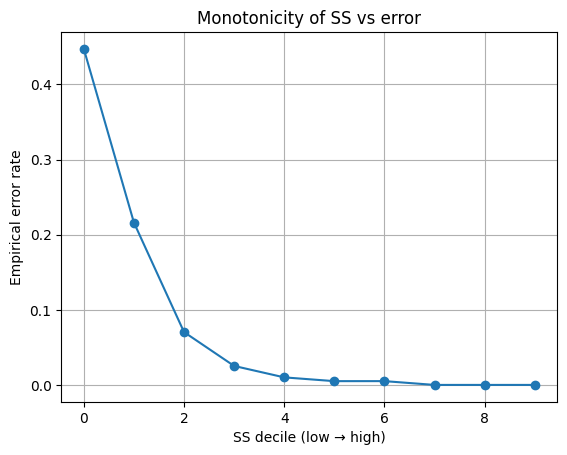

In [219]:
df = pd.DataFrame({"ss": ss, "correct": correct})
df["error"] = 1 - df["correct"]

# --- 1. Bin into deciles ---
df["decile"] = pd.qcut(df["ss"], 10, labels=False)

# --- 2. Compute error rate per decile ---
grouped = df.groupby("decile")["error"].mean()

plt.plot(grouped.index, grouped.values, marker="o")
plt.xlabel("SS decile (low → high)")
plt.ylabel("Empirical error rate")
plt.title("Monotonicity of SS vs error")
plt.grid(True)
plt.show()

In [220]:
import statsmodels.api as sm

# Use decile index as "trend variable"
df["decile_index"] = df["decile"].astype(int)

# Logistic regression: error ~ decile (trend test)
model = sm.Logit(df["error"], sm.add_constant(df["decile_index"]))
res = model.fit(disp=False)

print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                  error   No. Observations:                 1988
Model:                          Logit   Df Residuals:                     1986
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Nov 2025   Pseudo R-squ.:                  0.3760
Time:                        00:23:14   Log-Likelihood:                -339.61
converged:                       True   LL-Null:                       -544.27
Covariance Type:            nonrobust   LLR p-value:                 5.158e-91
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2292      0.126     -1.825      0.068      -0.475       0.017
decile_index    -1.0939      0.090    -12.132      0.000      -1.271      -0.917

Possibly complete quasi-separation: A fract

In [221]:
items = list(cf_results)
ss = np.array([float(s['ss']) for s in items])
cp = np.array([(1 - float(s['cp'])) for s in items])
model_prob = np.array([float(s['base_proba']) for s in items])
y_true = np.array([int(s['true_class']) for s in items])
y_pred = (model_prob >= 0.5).astype(int)
error = (y_pred != y_true).astype(int)   # 1 = wrong

In [222]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, brier_score_loss

X1 = sm.add_constant(ss)
X2 = sm.add_constant(np.column_stack([ss, cp]))

m1 = sm.Logit(error, X1).fit(disp=False)
m2 = sm.Logit(error, X2).fit(disp=False)

print(m1.summary())
print(m2.summary())

# Likelihood ratio test (deviance diff)
LR = 2*(m2.llf - m1.llf)
from scipy.stats import chi2
p_lr = chi2.sf(LR, df=1)   # 1 additional df for CP
print("LR stat:", LR, "p:", p_lr)

# ΔAUC and ΔBrier
pred1 = m1.predict(X1)
pred2 = m2.predict(X2)
auc1 = roc_auc_score(error, pred1)
auc2 = roc_auc_score(error, pred2)
b1 = brier_score_loss(error, pred1)
b2 = brier_score_loss(error, pred2)
print("AUC SS only:", auc1, "AUC SS+CP:", auc2, "ΔAUC:", auc2-auc1)
print("Brier SS only:", b1, "Brier SS+CP:", b2, "ΔBrier:", b2-b1)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1988
Model:                          Logit   Df Residuals:                     1986
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Nov 2025   Pseudo R-squ.:                  0.3149
Time:                        00:23:14   Log-Likelihood:                -372.89
converged:                       True   LL-Null:                       -544.27
Covariance Type:            nonrobust   LLR p-value:                 1.592e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3260      0.279      8.335      0.000       1.779       2.873
x1            -6.8246      0.432    -15.809      0.000      -7.671      -5.979
                           Logit Regression Results 

In [223]:
import pandas as pd
from sklearn.metrics import roc_auc_score

df = pd.DataFrame({"ss": ss, "cp": cp, "error": error})
df['ss_decile'] = pd.qcut(df['ss'], 10, labels=False, duplicates='drop')

decile_results = []
for d in sorted(df['ss_decile'].unique()):
    sub = df[df['ss_decile']==d]
    if len(sub['error'].unique())==1:
        auc = np.nan
    else:
        auc = roc_auc_score(sub['error'], sub['cp'])
    decile_results.append((d, sub.shape[0], sub['error'].mean(), auc))

# print table
import numpy as np
print("decile, n, error_rate, CP_AUC_within")
for d,n,err,auc in decile_results:
    print(d, n, f"{err:.3f}", "auc" if np.isnan(auc) else f"{auc:.3f}")


decile, n, error_rate, CP_AUC_within
0 199 0.447 0.361
1 199 0.216 0.541
2 199 0.070 0.518
3 198 0.025 0.617
4 199 0.010 0.645
5 199 0.005 0.561
6 198 0.005 0.878
7 199 0.000 auc
8 199 0.000 auc
9 199 0.000 auc


In [224]:
df = pd.DataFrame(decile_results)
df.columns = ['decile', 'n', 'error_rate', 'CP_AUC_within']

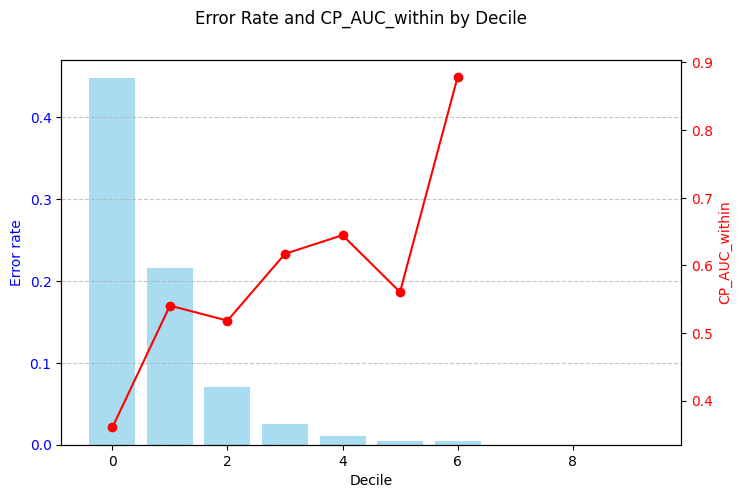

In [225]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar for error rate
ax1.bar(df["decile"], df["error_rate"], color="skyblue", alpha=0.7, label="Error rate")
ax1.set_xlabel("Decile")
ax1.set_ylabel("Error rate", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Line for CP_AUC_within
ax2 = ax1.twinx()
ax2.plot(df["decile"], df["CP_AUC_within"], color="red", marker="o", label="CP_AUC_within")
ax2.set_ylabel("CP_AUC_within", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Titles & grid
fig.suptitle("Error Rate and CP_AUC_within by Decile")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
